<div align="right">Python 2.7 Jupyter Notebook</div>

# Finding connected components using  clustering

<br><div class="alert alert-warning">
<b>Note that this notebook contains advanced exercises applicable only to students who wish to deepen their understanding and qualify for bonus marks on the course.</b> You will be able to achieve 100% for this notebook by only completing Exercise 1. Optional, additional exercises can be completed to qualify for bonus marks.
</div>


### Your completion of the notebook exercises will be graded based on your ability to do the following:

> **Understand**: Do your pseudo-code and comments show evidence that you recall and understand technical concepts?

> **Apply**: Are you able to execute code (using the supplied examples) that performs the required functionality on supplied or generated data sets? 

> **Analyze**: Are you able to pick the relevant method or  library to resolve specific stated questions?

> **Evaluate**: Are you able to interpret the results and justify your interpretation based on the observed data?

#### Notebook objectives
By the end of this notebook, you will be expected to:
> 
  - Find connected components in networks (using the techniques of hierarchical clustering, modularity maximization, and spectral graph partitioning); and
  - Interpret clustering results.
  
####  List of exercises
> - **Exercise 1**: Understanding hierarchical clustering.
- **Exercise 2 [Advanced]**: Interpreting the results of hierarchical clustering.
- **Exercise 3 [Advanced]**: Summarizing clustering results based on modularity maximization and spectral graph partitioning.

# Notebook introduction

Community detection is an important task in social network analysis. The idea behind it is to identify groups of people that share a common interest, based on the assumption that these people tend to link to each other more than to the rest of the network. Specifically, real-world networks exhibit clustering behavior that can be observed in the graph representation of these networks by the formation of clusters or partitions. These groups of nodes on a graph (clusters) correspond to communities that share common properties, or have a common role in the system under study.

Intuitively, it is expected that such clusters are associated with a high concentration of nodes. In the following examples, you will explore the identification of these clusters using the following approaches, as discussed in the video content:

- Hierarchical clustering (using a distance matrix)
- The Louvain Algorithm (using modularity maximization)
- Spectral graph partitioning

#### Import required modules

In [1]:
import networkx as nx
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pylab as plt
from networkx.drawing.nx_agraph import graphviz_layout

from collections import defaultdict, Counter
import operator

## For hierarchical clustering.
from scipy.cluster import hierarchy
from scipy.spatial import distance

## For spectral graph partitioning.
from sklearn.cluster import spectral_clustering as spc

## For Community Detection (Louvain Method).
import community

import sys
sys.path.append('..')
from utils import draw_partitioned_graph

plt.rcParams['figure.figsize'] = (15, 9)
plt.rcParams['axes.titlesize'] = 'large'

## 1. Data preparation

You are going to read the graph from an adjacency list saved in earlier exercises.

In [2]:
call_adjmatrix = pd.read_csv('./call.adjmatrix', index_col=0)
call_graph     = nx.from_numpy_matrix(call_adjmatrix.as_matrix())

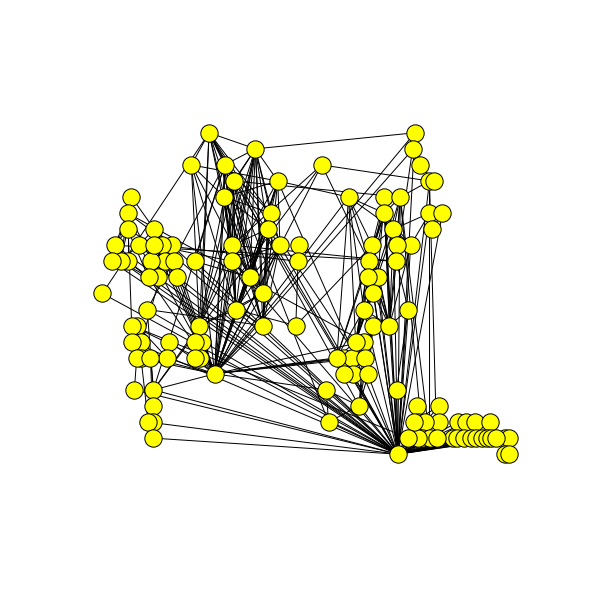

In [3]:
# Display call graph object.
plt.figure(figsize=(10,10))
plt.axis('off')

#pos = nx.spring_layout(call_graph)
pos = graphviz_layout(call_graph, prog='dot')
nx.draw(call_graph, pos=pos, node_color='yellow')

## 2. Hierarchical clustering

This notebook makes use of a hierarchical clustering algorithm, as implemented in [Scipy](http://docs.scipy.org/doc/scipy/reference/). The following example uses the average distance measure. Since the graph is weighted, you can also use the single linkage inter-cluster distance measure (see exercises).

In [8]:
def create_hc(G, linkage='average'):
    """
    Creates hierarchical cluster of graph G from distance matrix
    """ 
    
    path_length=nx.all_pairs_shortest_path_length(G)
    distances=np.zeros((len(G),len(G)))
    
    for u,p in path_length.items():
        for v,d in p.items():
            distances[G.nodes().index(u)][G.nodes().index(v)] = d
            distances[G.nodes().index(v)][G.nodes().index(u)] = d
            if u==v: distances[G.nodes().index(u)][G.nodes().index(u)]=0
    # Create hierarchical cluster.
    Y=distance.squareform(distances)
    if linkage == 'max':
        # Creates HC using farthest point linkage.
        Z=hierarchy.complete(Y)  
    if linkage == 'single':
        # Creates HC using closest point linkage.
        Z=hierarchy.single(Y)  
    if linkage == 'average':
        # Creates HC using closest point linkage.
        Z=hierarchy.average(Y)
        
    return Z

def get_cluster_membership(Z, maxclust):
    '''
    Assigns cluster membership by specifying cluster size.
    '''
    hc_out=list(hierarchy.fcluster(Z,maxclust, criterion='maxclust'))
    
    # Map cluster values to a dictionary variable.
    cluster_membership = {}
    i = 0
    for i in range(len(hc_out)):
        cluster_membership[i]=hc_out[i]
    
    
    return cluster_membership

Below is a demonstration of hierarchical clustering when applied to the call graph.

In [9]:
# Perform hierarchical clustering using 'average' linkage. 
Z = create_hc(call_graph, linkage='average') 

The dendrogram corresponding to the partitioned graph (illustrated above) is obtained as follows:

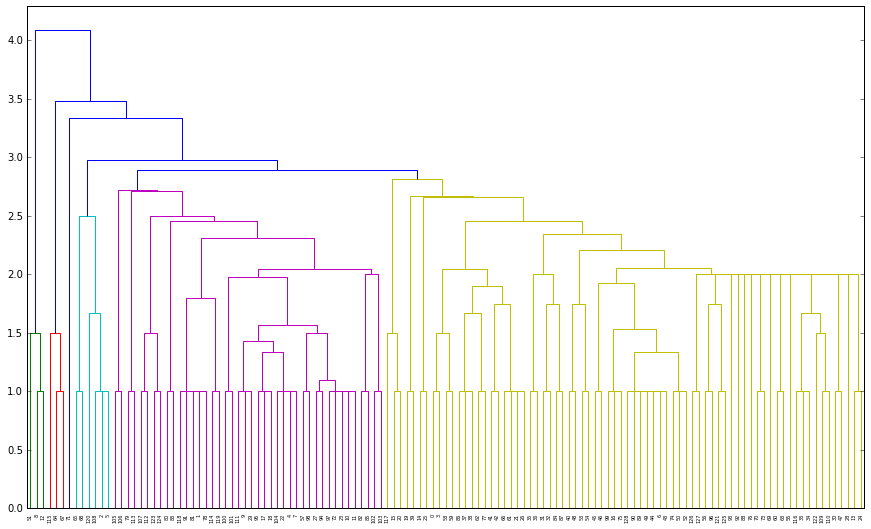

In [10]:
hierarchy.dendrogram(Z)
plt.show()

This dendrogram can help explain what happens as a result of the agglomerative method of hierarchical clustering. Starting at the bottom-most level, each node is assigned its own cluster. The closest pair of nodes (according to a distance function) are then merged into a new cluster. The distance matrix is recomputed, treating the merged cluster as an individual node. This process is repeated until the entire network has been merged into a single, large cluster, which the top level in the dendrogram above represents. You can now understand why this method is agglomerative.

The linkage function is used to determine the distance between a cluster and a node, or between two clusters, using the following possibilities:

- **Single:** Merge two clusters with the smallest minimum pairwise distance.
- **Average:** Merge two clusters with the smallest average pairwise distance.
- **Maximum or complete:** Merge the two clusters with the smallest maximum pairwise distance.

Now, you can finally retrieve the clusters, based on the analysis of the dendrogram. In this post-processing, there are different ways of determining $k$, the number of clusters to partition the data into. Scipy's hierarchical flat clustering function - "``hierarchy.fcluster()``" - is used to assign cluster membership by specifying a distance threshold, or the number of clusters required. In the function definition (above), you have been provided with a utility function, "``get_cluster_membership()``", which does the latter.

Selecting the number of clusters $k$ is, in general, an ill-posed problem. Different interpretations are possible, depending on the nature of the problem, the scale of the distribution of points in a data set, and the required clustering resolution. In agglomerative clustering, as used in the example above, you can get zero error for the objective function by considering each data point as its own cluster. Hence, the selection of $k$ invariably involves a trade-off maximum compression of the data (using a single cluster), and maximum accuracy by assigning each data point to its own cluster. In the following, the variation of the clustering error function, as the cluster size is increased, is shown on a scree plot, and the points of inflection ("knee points"), where such a trade-off is achieved, are highlighted.

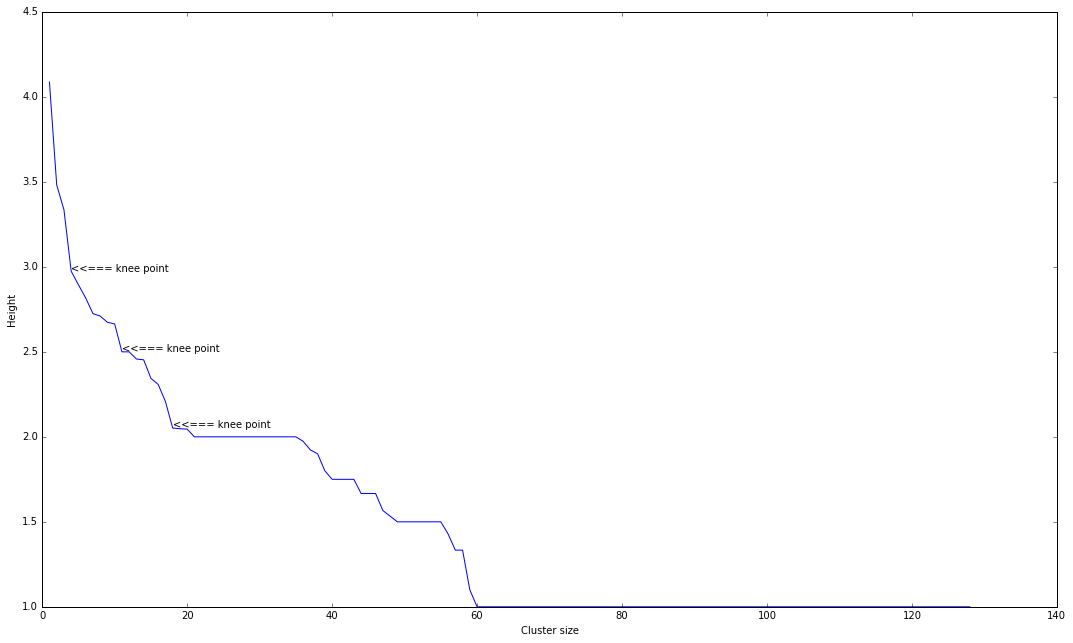

In [11]:
plt.plot(range(1, len(Z)+1), Z[::-1, 2])
knee = np.diff(Z[::-1, 2], 2)
#plt.plot(range(2, len(Z)), knee)
num_clust1 = knee.argmax() + 2
knee[knee.argmax()] = 0
num_clust1 = knee.argmax() + 2
knee[knee.argmax()] = 0
num_clust2 = knee.argmax() + 2
knee[knee.argmax()] = 0
num_clust3 = knee.argmax() + 2
plt.text(num_clust1, Z[::-1, 2][num_clust1-1], '<<=== knee point')
plt.text(num_clust2, Z[::-1, 2][num_clust2-1], '<<=== knee point')
plt.text(num_clust3, Z[::-1, 2][num_clust3-1], '<<=== knee point')

plt.xlabel('Cluster size')
plt.ylabel('Height',)
plt.tight_layout()
plt.show()

In [12]:
num_clust1, num_clust2, num_clust3

(4, 11, 18)

For the purposes of this illustrative example, suppose you conjecture that an optimal value is the mean of these three values.

In [13]:
opt_clust = round(1.0/3*(num_clust1+num_clust2+num_clust3))
opt_clust

11.0

You can now assign the data to these "``opt_clust``" clusters.

In [14]:
cluster_assignments = get_cluster_membership(Z, maxclust=opt_clust)

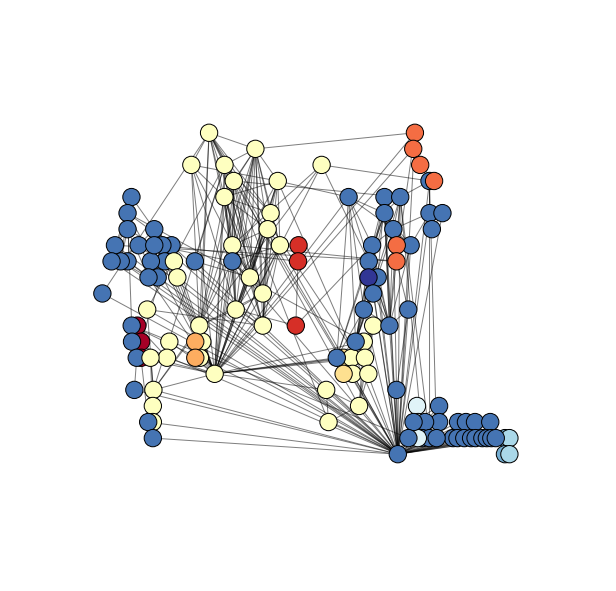

In [15]:
plt.figure(figsize=(10,10))
plt.axis('off')

pos = graphviz_layout(call_graph, prog='dot')

nx.draw_networkx_nodes(call_graph, pos=pos, cmap=plt.cm.RdYlBu, node_color=cluster_assignments.values())
nx.draw_networkx_edges(call_graph, pos=pos, alpha=0.5)
plt.show()

<br>
<div class="alert alert-info">
<b>Exercise 1 Start.</b>
</div>

### Instructions

> 1. How many clusters are obtained after the final step of agglomerative clustering (before post-processing)?
>> **Note:** Post-processing involves determining the optimal clusters for the problem at hand.
> 2. Based on your answer above, would you consider agglomerative clustering a top-down approach, or a bottom-up approach?
> 3. Which of the three linkage functions (i.e. single, average, or maximum or complete) do you think is likely to be most sensitive to outliers? 
>>**Hint**: Look at this [single-link and complete-link clustering](http://nlp.stanford.edu/IR-book/html/htmledition/single-link-and-complete-link-clustering-1.html) resource.

Your markdown answer here.

>1.The final step of agglomerative clustering (before post-processing) is a single cluster - obtained after the last linkage, at distance ~ 4.1. HAC begins with each node being its own cluster (maximum accuracy), then each subsequent step of the cluster merge is a trade-off between accuracy and increasing compression of the data, to a maximum compression of a single cluster. 


>2.The Agglomerative clustering method is definitely a bottom-up approach (unlike Divisive clustering) - as shown in the buildup of the dendogram, each observation starts in its own cluster, and pairs of clusters are then merged, as one moves up the hierarchy with increasing distance measure.


>3.The complete linkage function is most sensitive to outliers - because it examines the most dissimilar nodes (smallest maximum pairwise distance). In fact, it can sometimes be a problem if it pays too much attention to outlier points, that intuitively are known to not fit well into the global structure of the cluster.


<br>
<div class="alert alert-info">
<b>Exercise 1 End.</b>
</div>
> **Exercise complete**:

<br>
<div class="alert alert-info">
<b>Exercise 2 [Advanced] Start.</b>
</div>

### Instructions

> In this exercise, you will investigate the structural properties of the clusters generated from above.

> 1. Assign the values from your "cluster_assignments" to a Pandas DataFrame named "df1", with the column name "cluster_label".
>> **Hint**: The variable "``cluster_assignments``" is of type ``dict``. You will need to get the values component of this dict, **not** the keys.
> 2. Add a field called "participantID" to "df1", and assign to this the index values from the previously-loaded "``call_adjmatrix``" DataFrame.
> 3. Load the DataFrame containing the centrality measures that you saved in Notebook 1 of this module, into "df2".
> 4. Perform an inner join by merging "df1" and "df2" on the field "participantID". Assign the result of this join to variable "df3".
> 5. Perform a groupby on "df3" (using "cluster_label" field), and then evaluate the mean of the four centrality measures (using the "`agg()`" method). Assign the aggregation result to "df4".
> 6. Review "df4", and plot its barplot. 
> 7. Combine each set of clusters with the same mean values across all centrality measures into a single cluster. Assign the smallest value of the labels in the set to the merged cluster.
> 8. Print the size of each cluster, in descending order,  after performing the cluster merging in the preceding step.

In [16]:
# Your code here.

#### 1. Assign the values from your "cluster_assignments" to a Pandas DataFrame named "df1", with the column name "cluster_label".

In [16]:
df1 = pd.DataFrame(pd.Series(cluster_assignments),columns=['cluster_label'])
df1.head(3)

,cluster_label
0,10
1,6
2,3


In [18]:
#df1.describe()

#### 2. Add a field called "participantID" to "df1", and assign to this the index values from the previously-loaded "call_adjmatrix" DataFrame.

In [17]:
df1['participantID']=call_adjmatrix.index
df1.head(3)

,cluster_label,participantID
0,10,fa10-01-78
1,6,fa10-01-79
2,3,fa10-01-76


#### 3. Load the DataFrame containing the centrality measures that you saved in Notebook 1 of this module, into "df2".

In [18]:
#call_adjmatrix = pd.read_csv('./call.adjmatrix', index_col=0)
#df2= pd.read_csv('./centrality.csv')
df2= pd.read_csv('./centrality.csv')
df2.head(3)

,participantID,btn.centrality,clo.centrality,deg.centrality,eig.centrality
0,fa10-01-04,0.651025,0.624390,0.523438,0.213067
1,fa10-01-13,0.248733,0.477612,0.328125,0.326465
2,fa10-01-76,0.042644,0.465455,0.046875,0.066289


In [21]:
#df2.describe()

#### 4. Perform an inner join by merging "df1" and "df2" on the field "participantID". Assign the result of this join to variable "df3".

In [19]:
df3=pd.merge(df1,df2,how='inner',on=['participantID'])
df3.head(3)

,cluster_label,participantID,btn.centrality,clo.centrality,deg.centrality,eig.centrality
0,10,fa10-01-78,0.000041,0.328205,0.015625,0.007086
1,6,fa10-01-79,0.000000,0.323232,0.031250,0.009786
2,3,fa10-01-76,0.042644,0.465455,0.046875,0.066289


#### 5. Perform a groupby on "df3" (using "cluster_label" field), and then evaluate the mean of the four centrality measures (using the "agg()" method). Assign the aggregation result to "df4".

In [20]:
df4=df3.groupby('cluster_label').aggregate(np.mean)

#### 5. Review "df4", and plot its barplot.

In [21]:
df4.head(3)

,btn.centrality,clo.centrality,deg.centrality,eig.centrality
cluster_label,,,,
1,0.016153,0.257624,0.018229,0.001768
2,0.007986,0.293900,0.018229,0.008918
3,0.011942,0.345169,0.029948,0.025542


In [22]:
df4.describe()

,btn.centrality,clo.centrality,deg.centrality,eig.centrality
count,11.000000,11.000000,11.000000,11.000000
mean,0.009185,0.321369,0.023058,0.021555
std,0.004656,0.043649,0.018537,0.031453
min,0.000000,0.257624,0.007812,0.001768
25%,0.007812,0.289914,0.011719,0.007795
50%,0.007812,0.319081,0.018229,0.008918
75%,0.012745,0.339576,0.024089,0.019404
max,0.016153,0.398588,0.068257,0.111757


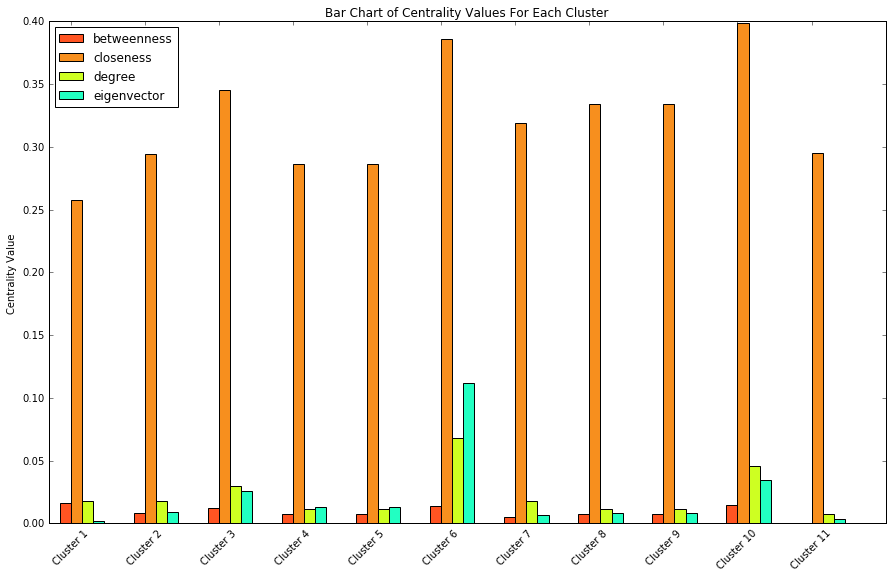

In [23]:
# the ideal barplot will be a grouped barchart comparing centrality values per cluster label
fig = plt.figure()
ax = fig.add_subplot(111)

## get the plot data
N = len(df4)
btnMeans = df4['btn.centrality']
cloMeans = df4['clo.centrality']
degMeans = df4['deg.centrality']
eigMeans = df4['eig.centrality']

## set the necessary variables
ind = np.arange(N)                # the x locations for the clusters
width = 0.15                      # the width of the bars

## set the bars for each centrality measure
bar1 = ax.bar(ind, btnMeans, width, color='#FF5422')
bar2 = ax.bar(ind+width, cloMeans, width, color='#F78F1E')
bar3 = ax.bar(ind+width+width, degMeans, width, color='#CEFF22')
bar4 = ax.bar(ind+width+width+width, eigMeans, width, color='#22FFC2')

# define the axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,0.4)
ax.set_ylabel('Centrality Value')
ax.set_title('Bar Chart of Centrality Values For Each Cluster')
xTickMarks = ['Cluster '+str(i) for i in range(1,12)]
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=10)

## add a legend on the top left corner
plt.legend(['betweenness', 'closeness', 'degree', 'eigenvector'], loc='upper left')

plt.show()

#### Observations:

>* NB2's study of different methods to obtain centrality has already shown that this can be inconsistent
>* I recall from NB2 that for network centrality visualisation, closeness centrality showed the least blue dots, meaning high centrality value. This is validated in the bar chart (orange bar).
>* High closeness values means in the Friends and Family resident living community, calls are mainly made to close family members, as with couples who can communicate quickly.
>* Next best cluster centrality measure is eigenvector. In the NB2 visualisation, we also see more colour dots other than low values blue. This means the presence of important people in the F&F community, with connections to important neighbors.
>* Betweenness did badly, which means there are hardly any node that lie on a high proportion of paths between other nodes in the cluster... no messenger types in the F & F community.

#### 6. Combine each set of clusters with the same mean values across all centrality measures into a single cluster. Assign the smallest value of the labels in the set to the merged cluster.

In [24]:
# I will print the matrix dataframe to visually inspect which clusters are good for a merge
df4

,btn.centrality,clo.centrality,deg.centrality,eig.centrality
cluster_label,,,,
1,0.016153,0.257624,0.018229,0.001768
2,0.007986,0.293900,0.018229,0.008918
3,0.011942,0.345169,0.029948,0.025542
4,0.007812,0.285927,0.011719,0.013266
5,0.007812,0.285927,0.011719,0.013266
6,0.013549,0.385949,0.068257,0.111757
7,0.005249,0.319081,0.018229,0.006932
8,0.007812,0.333983,0.011719,0.008659
9,0.007812,0.333983,0.011719,0.008659


In [25]:
# Clusters 4+5, and 8+9 are the clusters I want
# I'll next do a quick size of each cluster label to understand what clusters 4+5,and 8+9 should add to
df1.groupby('cluster_label').size()

cluster_label
1      3
2      3
3      6
4      2
5      2
6     38
7      3
8      2
9      2
10    67
11     1
dtype: int64

In [34]:
# I'll then create a new df to keep only cluster sizes after a groupby 'cluster_label
dfy = pd.DataFrame(df1.groupby(['cluster_label']).size(), 
                                columns=['counts']).reset_index()
dfy

,cluster_label,counts
0,1,3
1,2,3
2,3,6
3,4,2
4,5,2
5,6,38
6,7,3
7,8,2
8,9,2
9,10,67


In [35]:
# I will then merge 4+5 into cluster 4,  8+9 into cluster 8, by adding their counts
dfy.counts[3] = dfy.counts[3] + dfy.counts[4]
dfy.counts[7] = dfy.counts[7] + dfy.counts[8]

In [41]:
# Next is to reassign cluster labels to fill in the "gaps" after a merge
# Effectively, I am reassigning these clusters 6=>5 ; 7=>6 ; 8=>7; 10=>8; 11=>9 
dfy.counts[4] = dfy.counts[5]
dfy.counts[5] = dfy.counts[6]
dfy.counts[6] = dfy.counts[7]
dfy.counts[7] = dfy.counts[9]
dfy.counts[8] = dfy.counts[10]
#dfy

In [37]:
# Next to drop clusters > 9
dfz = dfy[dfy.cluster_label <= 9]

#### 7. Print the size of each cluster, in descending order, after performing the cluster merging in the preceding step.

In [39]:
# A sort by descending 
dfa = dfz.sort_values(by=['counts'],ascending=False)
dfa

,cluster_label,counts
7,8,67
4,5,38
2,3,6
3,4,4
6,7,4
0,1,3
1,2,3
5,6,3
8,9,1


In [40]:
# Number of unique actors associated with each of the five participants with highest degree centrality measure.
print ('-------------- Cluster Sizes in Descending Order ------------')
for i in range(0, len(dfa)):
    print('Cluster Label: {0}       -------> \t Size of Cluster: {1}'.format(dfa.iloc[i]['cluster_label'],dfa.iloc[i]['counts']))

-------------- Cluster Sizes in Descending Order ------------
Cluster Label: 8       -------> 	 Size of Cluster: 67
Cluster Label: 5       -------> 	 Size of Cluster: 38
Cluster Label: 3       -------> 	 Size of Cluster: 6
Cluster Label: 4       -------> 	 Size of Cluster: 4
Cluster Label: 7       -------> 	 Size of Cluster: 4
Cluster Label: 1       -------> 	 Size of Cluster: 3
Cluster Label: 2       -------> 	 Size of Cluster: 3
Cluster Label: 6       -------> 	 Size of Cluster: 3
Cluster Label: 9       -------> 	 Size of Cluster: 1


#### Observations:
>* Cluster size does not neccesarily equate to cluster quality, eg. the largest cluster sizes (nodes 5 & 8) do not have the highest btn and clo centrality values. Similarly the smallest cluster sizes, eg. nodes 1,2 & 7, showed higher centrality values than other nodes.
>* From the Friends and Family metadata description, we can deduce some ground truth about the data. It is likely that the 2 node clusters that were merged are 4 pairs of couple participants in the family residential living community.
>* Since they formed their own clusters (sub community), it can be implied that these 4 couples are socially isolated (shown by low deg centrality), yet amongst themselves they are quite well connected,probably belonging to the same clubs, going the same places, maybe same ethnicity, religion etc.. etc..

<br>
<div class="alert alert-info">
<b>Exercise 2 [Advanced] End.</b>
</div>
> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

## 3. Community detection
Community detection is an important component in the analysis of large and complex networks. Identifying these subgraph structures helps in understanding organizational and functional characteristics of the underlying physical networks. In this section, you will study a few  approaches that are widely used in community detection using graph representations.

### 3.1 The Louvain modularity-maximization approach

The Louvain method is one of the most widely-used methods for detecting communities in large networks. It was developed by a team of researchers at the Université catholique de Louvain. The method can unveil hierarchies of communities, and allows you to zoom within communities in order to discover sub-communities, sub-sub-communities, and so forth. The modularity QQ quantifies how good a "community" or partition is, and is defined as follows:

$$Q_c =\frac{1}{2m}\sum _{(ij)} \left [ A_{ij}-\frac{k_ik_j}{2m} \right] \delta(c_i, c_j)$$

The higher the $Q_c$ of a community is, the better the partition is.

The Louvain method is a greedy optimization method that attempts to optimize the "modularity" of a partition of the network via two steps:

1. Locally optimize the modularity to identify "small" communities.
2. Aggregate nodes belonging to the same community, and create a new network with aggregated nodes as individual nodes.

Steps 1 and 2 are then repeated until a maximum of modularity produces a hierarchy of communities.

Now you have the opportunity to identify communities in the “Family and Friends” call data set. First, compute the best partition.

In [42]:
louvain_partition = community.best_partition(call_graph)

Then, identify and label the communities. This process should be similar to what you did when using agglomerative hierarchical clustering.

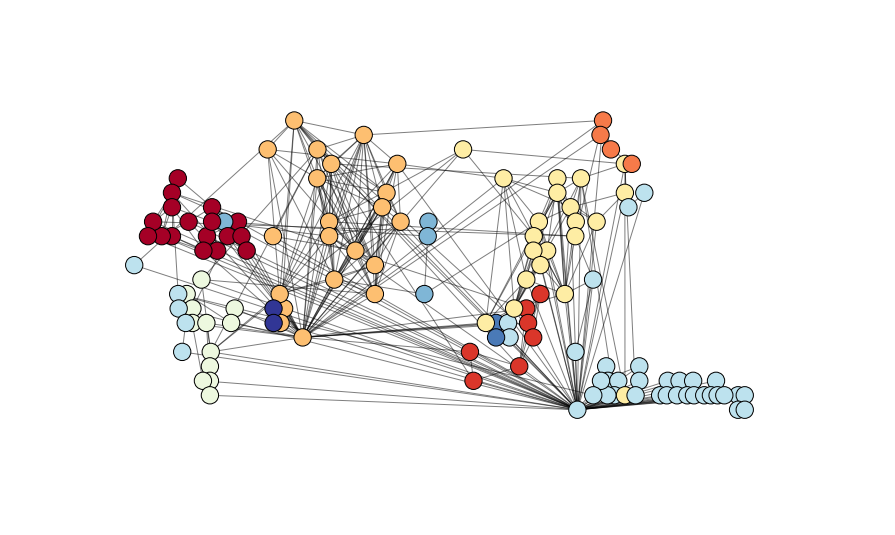

In [43]:
pos = graphviz_layout(call_graph, prog='dot')
nx.draw_networkx_nodes(call_graph, pos, cmap=plt.cm.RdYlBu, node_color=louvain_partition.values())
nx.draw_networkx_edges(call_graph, pos, alpha=0.5)
plt.axis('off')
plt.show()

Nodes that are close share the same color and, therefore, belong to the same cluster (despite the poor reflection of this in the visualization).

In [187]:
# You can uncomment the line below to view the louvain_partition variable.
#louvain_partition

### 3.2 Spectral graph partitioning

Spectral graph partitioning and clustering is based on the spectrum — the eigenvalues and associated eigenvectors — of the Laplacian matrix that corresponds to a given graph. The approach is mathematically complex, but involves performing a $k$-means clustering, on a spectral projection of the graph, with $k$=2 (using an adjacency matrix as the affinity). A schematic illustration of the process is depicted in the figure below.

**Optional**: You can read more about [spectral graph processing](https://devblogs.nvidia.com/parallelforall/fast-spectral-graph-partitioning-gpus/).

<img src="img\spectral_graph_part.png", width=750, height=550>

Now, apply spectral graph partitioning to your call graph, and visualize the resulting community structure. You can read more about [Scikit-Learn](http://scikit-learn.org/stable/index.html), and the [Spectral Clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html) function utilized in this section. Spectral graph partitioning needs input in the form of the number of clusters sought (default setting is 8). There are various approaches one can take to optimize the final number of clusters, depending on problem domain knowledge. Below you will use a value of $k=9$.

In [188]:
# Create the spectral partition using the spectral clustering function from Scikit-Learn.
spectral_partition = spc(call_adjmatrix.as_matrix(), 9, assign_labels='discretize')

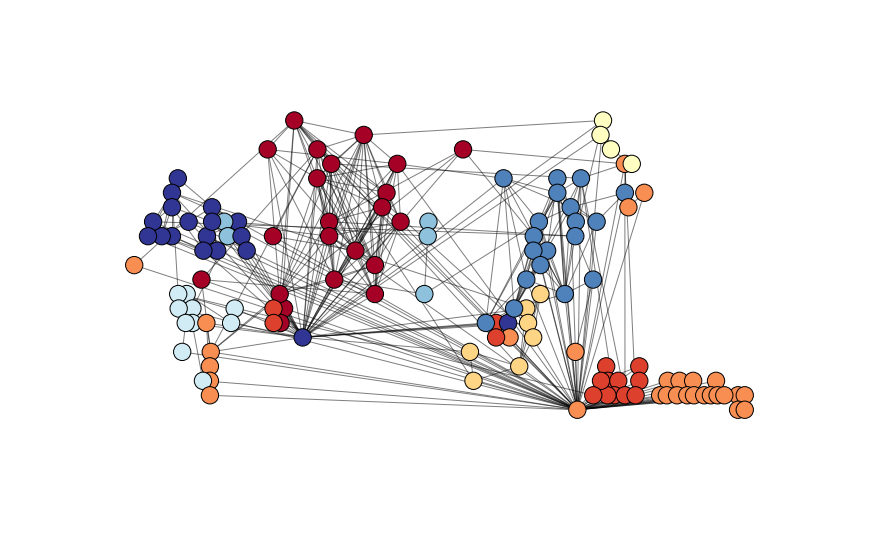

In [189]:
pos = graphviz_layout(call_graph, prog='dot')
nx.draw_networkx_nodes(call_graph, pos, cmap=plt.cm.RdYlBu, node_color=spectral_partition)
nx.draw_networkx_edges(call_graph, pos, alpha=0.5)
plt.axis('off')
plt.show()

#### Observations:
>* Hmm.. both the Louvian and Spectral Graph method methods show quite similar visualisations
>* The number of clusters (colours) in both methods also seem to validate the 8 to 11 cluster numbers in Ex2.

In [190]:
spectral_partition

array([8, 3, 4, 8, 0, 4, 7, 0, 5, 0, 0, 0, 5, 2, 2, 1, 7, 0, 0, 2, 1, 8, 0,
       0, 2, 2, 8, 0, 2, 0, 2, 5, 5, 2, 7, 6, 6, 8, 8, 2, 7, 8, 8, 7, 7, 7,
       2, 2, 7, 7, 7, 5, 7, 2, 2, 0, 1, 0, 8, 8, 2, 8, 8, 2, 6, 7, 8, 6, 7,
       2, 2, 7, 0, 2, 7, 7, 2, 0, 3, 1, 8, 3, 8, 2, 5, 8, 8, 5, 2, 7, 7, 3,
       2, 2, 0, 0, 1, 0, 0, 7, 0, 0, 5, 5, 0, 1, 1, 2, 4, 1, 1, 8, 2, 1, 3,
       6, 1, 1, 3, 3, 4, 1, 1, 2, 2, 1, 5, 2, 2])

<br>
<div class="alert alert-info">
<b>Exercise 3 [Advanced] Start.</b>
</div>

### Instructions
Compute the size of the clusters obtained using:
>   1. The Louvain method; and
>   2. Spectral graph partitioning.
    

In [191]:
# Your code here.

#### 1. Compute size of the clusters obtained by the Louvain method

In [192]:
# make a df of the louvain_partition dict
dfl1 = pd.DataFrame(pd.Series(louvain_partition))
dfl1.columns=['cluster_label']
#dfs1

In [195]:
# make another df to capture the size of a groupby 'cluster_label)
dfl2 = pd.DataFrame(dfl1.groupby('cluster_label').size().rename('cluster_size'))
dfl2

,cluster_size
cluster_label,
0,17
1,7
2,4
3,21
4,21
5,12
6,39
7,4
8,2


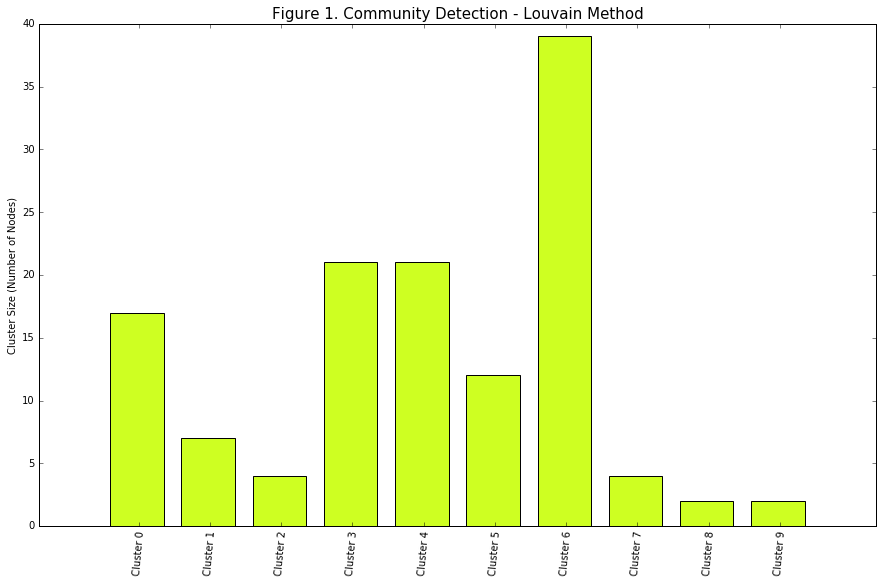

In [196]:
# there were 10 clusters, with max size 39 nodes
# I will plot a nice bar graph to show the distribution of cluster sizes
fig = plt.figure()
ax = fig.add_subplot(111)

## get the plot data
N = len(dfl2)
csize = dfl2['cluster_size']

## set the necessary variables
ind = np.arange(N)                # the x locations for the clusters
width = 0.75                      # the width of the bars

## set the bars for each centrality measure
bar1 = ax.bar(ind, csize, width, color='#CEFF22')
# other contrasting colour choices: '#FF5422','#F78F1E','#CEFF22''#22FFC2'

# define the axes and labels
#ax.set_xlim(-width,len(ind)+width)
ax.set_xlim(-1,len(ind)+width)
ax.set_ylim(0,40)
ax.set_ylabel('Cluster Size (Number of Nodes)')
ax.set_title('Figure 1. Community Detection - Louvain Method', fontsize=15)
xTickMarks = ['Cluster '+str(i) for i in range(0,19)]
ax.set_xticks(ind+0.4)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=85, fontsize=10)

## add a legend on the top left corner
#plt.legend(['leg1', 'leg2', 'leg3', 'leg4'], loc='upper left')

plt.show()

#### 2. Compute size of the clusters obtained by Spectral Graph Partitioning method

In [197]:
# make a df of the louvain_partition dict
dfs1 = pd.DataFrame(pd.Series(spectral_partition))
dfs1.columns=['cluster_label']
#dfs1

In [198]:
# make another df to capture the size of a groupby 'cluster_label)
dfs2 = pd.DataFrame(dfs1.groupby('cluster_label').size().rename('cluster_size'))
dfs2

,cluster_size
cluster_label,
0,22
1,15
2,29
3,7
4,4
5,10
6,5
7,19
8,18


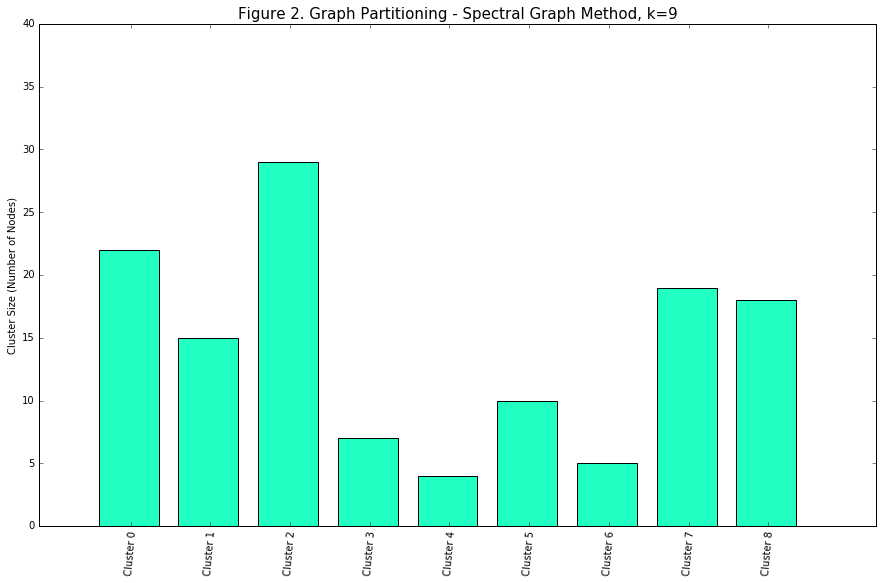

In [199]:
# there are 9 clusters with max size 29
# Plot a nice bar graph to show the distribution of cluster sizes
fig = plt.figure()
ax = fig.add_subplot(111)

## get the plot data
N = len(dfs2)
csize = dfs2['cluster_size']

## set the necessary variables
ind = np.arange(N)                # the x locations for the clusters
width = 0.75                      # the width of the bars

## set the bars for each centrality measure
bar1 = ax.bar(ind, csize, width, color='#22FFC2')
# other contrasting colour choices: '#FF5422','#F78F1E','#CEFF22''#22FFC2'

# define the axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,40)
ax.set_ylabel('Cluster Size (Number of Nodes)')
ax.set_title('Figure 2. Graph Partitioning - Spectral Graph Method, k=9', fontsize=15)
xTickMarks = ['Cluster '+str(i) for i in range(0,9)]
ax.set_xticks(ind+0.4)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=85, fontsize=10)

## add a legend on the top left corner
#plt.legend(['leg1', 'leg2', 'leg3', 'leg4'], loc='upper left')

plt.show()

#### Observations:
>* The Louvain method (Figure 1) detected a total of 10 clusters, ie. when modularity cannot increase any more..
>* The Louvain method detected 1 significant clusters of ~ 40 nodes, about 4 clusters of medium size (12-22), and the remaining 5 clusters are small sizes of < 6 nodes
>* Unlike the Louvain (community detection) method, spectral graph method can control the number and size of clusters specified. Hence using a k=9 cluster number specification as input, the network structure produced exactly 9 clusters (Figure 2).
>* Figure 2 also shows a more even cluster distribution where there are no strongly dominant clusters.
>* It is interesting that even though the graph partitioning uses an input value of 9 clusters (k=9), in the end the network structure is quite agreeable with the Louvain community detection method, which returned 10 clusters, again confirming the observations made earlier about the visualisation graphs - that they look very similar, for the Friends and Family call data. 


<br>
<div class="alert alert-info">
<b>Exercise 3 [Advanced] End.</b>
</div>
> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

## 4. Submit your notebook

Please make sure that you:
- Perform a final "Save and Checkpoint";
- Download a copy of the notebook in ".ipynb" format to your local machine using "File", "Download as", and "IPython Notebook (.ipynb)"; and
- Submit a copy of this file to the Online Campus.